# Why are the measures so similar?

If the voltage shapes are very similar, then $(V-E_{Na})$ is just a proportionality factor. In that case, both metrics will be very similar.

What if the voltage shapes are not similar, e.g. one spike is high and one is low? The big part of the energy is consumed when $(V - E_{Na})$ is large, i.e. in the regime where the spikes are still in their "early phase". This phase exists in both high and low spikes and within this range, the voltage waveforms are very similar. The difference in voltage waveforms only appears at high voltages (one spike still increasing, other flattening out). However, in this regime, the consumed energy is generally low due to a low $(V - E_{Na})$.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pyloric import simulate, create_prior, summary_stats
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time
import torch
from matplotlib.patches import Rectangle
import stg_energy.fig1_energy.viz_appendix as viz
from sklearn.linear_model import LinearRegression

prior = create_prior()

In [3]:
def curr_currents(params_with_seeds):
    p1 = create_prior()
    pars = p1.sample((1,))
    column_names = pars.columns

    parameter_set_pd = pd.DataFrame(
        np.asarray([params_with_seeds[:-1]]), columns=column_names
    )
    out_target = simulate(
        parameter_set_pd.loc[0],
        seed=int(params_with_seeds[-1]),
        dt=0.025,
        t_max=11000,
        temperature=283,
        noise_std=0.001,
        track_energy=True,
        track_currents=True,
        energy_measure="power"
    )
    return out_target

In [4]:
theta = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl"
)
x = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl"
)
seeds = np.load(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy"
)

In [5]:
n_samp = 20
samples = theta[:n_samp]
data_np = samples.to_numpy()
params_with_seeds = np.concatenate((data_np, np.expand_dims(seeds[:n_samp], axis=1)), axis=1)

In [6]:
with Pool(16) as pool:
    start_time = time.time()
    data1 = pool.map(curr_currents, params_with_seeds)
    print("Simulation time", time.time() - start_time)

Simulation time 9.158530712127686


# Sodium

In [7]:
conductance_ind = 0
reversal_potential = 50

In [8]:
time_vec = np.arange(0, 11000, 0.025)

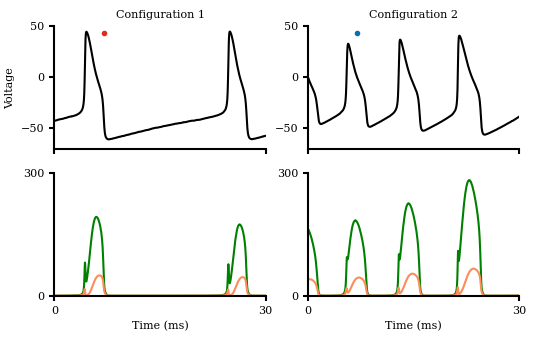

In [9]:
ratio0, ratio1 = viz.generate_figure_small(data1, time_vec, conductance_ind, reversal_potential, 43300, 44500, ind1=0, ind2=2, name="1")

In [10]:
ratio0, ratio1

(0.2183603149934032, 0.22197936874312887)

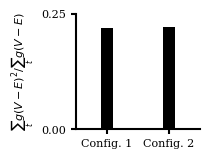

In [11]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.6, 1.5))
    ax.bar([0, 1], [ratio0, ratio1], color="k", width=0.2)
    ax.set_ylim([0, .25])
    ax.set_yticks([0, .25])
    ax.set_ylabel(r"$\sum_t g(V-E)^2/\sum_t g(V-E)$")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Config. 1", "Config. 2"])
    ax.add_patch(Rectangle((-0.2, 0.34), 0.2, 0.1,  color="g"))
    ax.add_patch(Rectangle((-0.2, 0.54), 0.2, 0.1,  color="#fc8d59"))
    ax.set_xlim([-.5, 1.5])
    plt.savefig("../svg/panel_explanation_of_proportionality_c1.svg")

# Energy computation based on sodium

In [12]:
powers = []
currents = []
for index in range(20):
    _, power, current = viz.energy_of_current(data1, index, conductance_ind, reversal_potential, 40000, 440000)
    powers.append(np.sum(power) / 10 / 1000 / 1000 * 0.025)
    currents.append(np.sum(current) / 10 / 1.6 / 3 / 1000 * 0.025)
rho = np.corrcoef(powers, currents)[0, 1]
print(rho)

0.999135660580136


In [13]:
powers = np.asarray(powers)
currents = np.asarray(currents)

regressor = LinearRegression()
fitted_reg = regressor.fit(powers[:, None], currents[:, None])
coeff = np.asarray([fitted_reg.coef_[0]])[0, 0]
print(coeff)

4.9449320565833945


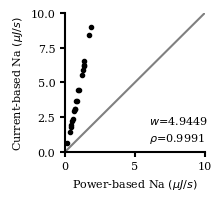

In [14]:
n = n_samp
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.8))
    _ = ax.scatter(powers, currents, c="k")
    ax.plot([0, 10], [0, 10], c="gray")
    ax.set_xlabel("Power-based Na "+r"$(\mu J/s)$")
    ax.set_ylabel("Current-based Na "+r"$(\mu J/s)$")
    ax.text(6.0, 2.0, r"$w$" + f"={coeff:.4f}")
    ax.text(6.0, 0.8, r"$\rho$" + f"={rho:.4f}")
    ax.set_xlim([0, 10])
    ax.set_ylim([0, 10])
    plt.savefig("../svg/panel_explanation_of_proportionality_d1_large.svg")

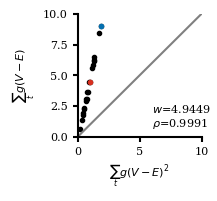

In [25]:
n = n_samp
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.6, 1.6))
    _ = ax.scatter(powers, currents, c="k")
    _ = ax.scatter(powers[0], currents[0], c="#d7301f")
    _ = ax.scatter(powers[2], currents[2], c="#0570b0")
    ax.plot([0, 10], [0, 10], c="gray")
    ax.set_xlabel(r"$\sum_t g(V-E)^2$")
    ax.set_ylabel(r"$\sum_t g(V-E)$")
    ax.text(6.0, 2.0, r"$w$" + f"={coeff:.4f}")
    ax.text(6.0, 0.8, r"$\rho$" + f"={rho:.4f}")
    ax.set_xlim([0, 10])
    ax.set_ylim([0, 10])
    plt.savefig("../svg/panel_explanation_of_proportionality_d1.svg")

# Energy based on calcium CaT

In [16]:
powers = []
currents = []
for index in range(20):
    _, power, current = viz.energy_of_current(data1, index, 1, data1[index]["reversal_calcium"][0][40000:], 40000, 440000)
    powers.append(np.sum(power) / 10 / 1000 / 1000 * 0.025)
    currents.append(np.sum(current) / 10 / 1.6 / 4 / 1000 * 0.025)
rho = np.corrcoef(powers, currents)[0, 1]
print(rho)

0.9787417755859061


In [17]:
powers = np.asarray(powers)
currents = np.asarray(currents)

regressor = LinearRegression()
fitted_reg = regressor.fit(powers[:, None], currents[:, None])
coeff = np.asarray([fitted_reg.coef_[0]])[0, 0]
print(coeff)

2.323331264302049


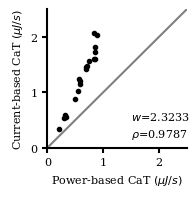

In [18]:
n = n_samp
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.8))
    _ = ax.scatter(powers, currents, c="k")
    ax.plot([0, 2.5], [0, 2.5], c="gray")
    ax.set_xlabel("Power-based CaT "+r"$(\mu J/s)$")
    ax.set_ylabel("Current-based CaT "+r"$(\mu J/s)$")
    ax.text(1.5, 0.5, r"$w$" + f"={coeff:.4f}")
    ax.text(1.5, 0.2, r"$\rho$" + f"={rho:.4f}")
    ax.set_xlim([0, 2.5])
    ax.set_ylim([0, 2.5])
    plt.savefig("../svg/panel_explanation_of_proportionality_d2.svg")

# Energy based on calcium CaS

In [19]:
powers = []
currents = []
for index in range(20):
    _, power, current = viz.energy_of_current(data1, index, 2, data1[index]["reversal_calcium"][0][40000:], 40000, 440000)
    powers.append(np.sum(power) / 10 / 1000 / 1000 * 0.025)
    currents.append(np.sum(current) / 10 / 1.6 / 4 / 1000 * 0.025)
rho = np.corrcoef(powers, currents)[0, 1]
print(rho)

0.9659757353174357


In [20]:
powers = np.asarray(powers)
currents = np.asarray(currents)

regressor = LinearRegression()
fitted_reg = regressor.fit(powers[:, None], currents[:, None])
coeff = np.asarray([fitted_reg.coef_[0]])[0, 0]
print(coeff)

2.403180767168554


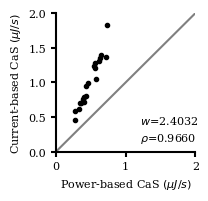

In [21]:
n = n_samp
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.8))
    _ = ax.scatter(powers, currents, c="k")
    ax.plot([0, 2], [0, 2], c="gray")
    ax.set_xlabel("Power-based CaS "+r"$(\mu J/s)$")
    ax.set_ylabel("Current-based CaS "+r"$(\mu J/s)$")
    ax.text(1.2, 0.4, r"$w$" + f"={coeff:.4f}")
    ax.text(1.2, 0.15, r"$\rho$" + f"={rho:.4f}")
    ax.set_xlim([0, 2])
    ax.set_ylim([0, 2])
    plt.savefig("../svg/panel_explanation_of_proportionality_d3.svg")

# Energy based on potassium Kd

In [22]:
powers = []
currents = []
for index in range(20):
    _, power, current = viz.energy_of_current(data1, index, 2, -80, 40000, 440000)
    powers.append(np.sum(power) / 10 / 1000 / 1000 * 0.025)
    currents.append(np.sum(current) / 10 / 1.6 / 2 / 1000 * 0.025)
rho = np.corrcoef(powers, currents)[0, 1]
print(rho)

0.9966936345011851


In [23]:
powers = np.asarray(powers)
currents = np.asarray(currents)

regressor = LinearRegression()
fitted_reg = regressor.fit(powers[:, None], currents[:, None])
coeff = np.asarray([fitted_reg.coef_[0]])[0, 0]
print(coeff)

4.604149268898411


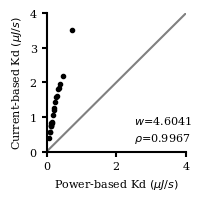

In [24]:
n = n_samp
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.8))
    _ = ax.scatter(powers, currents, c="k")
    ax.plot([0, 4], [0, 4], c="gray")
    ax.set_xlabel("Power-based Kd "+r"$(\mu J/s)$")
    ax.set_ylabel("Current-based Kd "+r"$(\mu J/s)$")
    ax.set_xlim([0, 4])
    ax.set_ylim([0, 4])
    ax.text(2.5, 0.8, r"$w$" + f"={coeff:.4f}")
    ax.text(2.5, 0.3, r"$\rho$" + f"={rho:.4f}")
    plt.savefig("../svg/panel_explanation_of_proportionality_d4.svg")

# All of them (ensure that our computation is correct)

In [25]:
all_all = []
reversals = [50, 0, 0, -80, -80, -80, -20, -50]
for neuron in range(3):
    all_powers = []
    for ci in range(8):
        powers = []
        for index in range(20):
            if ci == 1 or ci == 2:
                _, power, current = viz.energy_of_current(data1, index, ci, data1[index]["reversal_calcium"][neuron][40000:], 40000, 440000, neuron)
            else:
                _, power, current = viz.energy_of_current(data1, index, ci, reversals[ci], 40000, 440000, neuron)
            powers.append(np.sum(power) / 1000 * 0.025)
        all_powers.append(powers)
    all_all.append(all_powers)
all_all = np.asarray(all_all)
power_computed_manually = np.sum(all_all, axis=0)
power_computed_manually = np.sum(power_computed_manually, axis=0)

In [26]:
e = []
for ii in range(20):
    stats = summary_stats(data1[ii], stats_customization={"energies":True})
    e.append(np.sum(stats["energies"].to_numpy(), axis=1))
e = np.asarray(e)

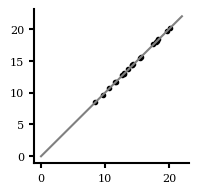

In [27]:
n = n_samp
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    _ = ax.scatter(power_computed_manually / 10 / 1000, e / 10 / 1000, c="k")
    ax.plot([0, 22], [0, 22], c="gray")

# Show correlation between E_power^Na and E_power^{Na,CaS,CaT}

In [28]:
all_all = []
reversals = [50, 0, 0, -80, -80, -80, -20, -50]
for neuron in range(1):
    all_powers = []
    for ci in range(3):
        powers = []
        for index in range(20):
            if ci == 1 or ci == 2:
                _, power, current = viz.energy_of_current(data1, index, ci, data1[index]["reversal_calcium"][neuron][40000:], 40000, 440000, neuron)
            else:
                _, power, current = viz.energy_of_current(data1, index, ci, reversals[ci], 40000, 440000, neuron)
            powers.append(np.sum(power) / 1000 * 0.025)
        all_powers.append(powers)
    all_all.append(all_powers)
all_all = np.asarray(all_all)
power_computed_manually = np.sum(all_all, axis=0)
power_computed_manually = np.sum(power_computed_manually, axis=0)

In [29]:
all_relevant = all_all[0] # Get rid of neuron batch dimension

In [30]:
sodium_power = all_relevant[0]
sodium_calcium_power = np.sum(all_relevant, axis=0)

In [31]:
rho = np.corrcoef(sodium_power, sodium_calcium_power)[0, 1]
print(rho)

0.9861668124016151


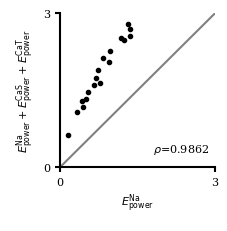

In [32]:
n = n_samp
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    _ = ax.scatter(sodium_power / 10 / 1000, sodium_calcium_power / 10 / 1000, c="k")
    ax.plot([0, 3], [0, 3], c="gray")
    ax.set_xlim([0, 3])
    ax.set_xticks([0, 3])
    ax.set_ylim([0, 3])
    ax.set_yticks([0, 3])
    ax.text(1.8, 0.3, r"$\rho$"+f"={rho:.4f}")
    ax.set_xlabel(r"$E_{\mathrm{power}}^{\mathrm{Na}}$")
    ax.set_ylabel(r"$E_{\mathrm{power}}^{\mathrm{Na}}+E_{\mathrm{power}}^{\mathrm{CaS}}+E_{\mathrm{power}}^{\mathrm{CaT}}$")
    plt.savefig("../svg/panel_explanation_of_proportionality_e1.svg")

## Show correlation between E_power^{Na,CaS,CaT} and E_current^{Na,CaS,CaT}

In [33]:
reversals = [50, 0, 0, -80, -80, -80, -20, -50]
pump_factors = [3, 4, 4, 2, 2, 2, 2, 2]
all_powers = []
all_currents = []
for ci in range(3):
    powers = []
    currents = []
    for index in range(20):
        if ci == 1 or ci == 2:
            _, power, current = viz.energy_of_current(data1, index, ci, data1[index]["reversal_calcium"][neuron][40000:], 40000, 440000, neuron)
        else:
            _, power, current = viz.energy_of_current(data1, index, ci, reversals[ci], 40000, 440000, neuron)
        powers.append(np.sum(power) / 1000 * 0.025)
        currents.append(np.sum(current) / 1000 * 0.025 / pump_factors[ci])
    all_powers.append(powers)
    all_currents.append(currents)

all_powers = np.asarray(all_powers)
all_currents = np.asarray(all_currents)

power_sodium_calcium = np.sum(all_powers, axis=0)
current_sodium_calcium = np.sum(all_currents, axis=0)

In [34]:
rho = np.corrcoef(power_sodium_calcium, current_sodium_calcium)[0, 1]
print(rho)

0.993984278786983


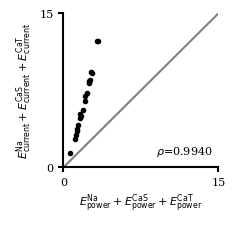

In [35]:
n = n_samp
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    _ = ax.scatter(power_sodium_calcium / 10 / 1000, current_sodium_calcium / 10 / 1.6, c="k")
    ax.plot([0, 15], [0, 15], c="gray")
    ax.set_xlim([0, 15])
    ax.set_xticks([0, 15])
    ax.set_ylim([0, 15])
    ax.set_yticks([0, 15])
    ax.text(9.0, 1.3, r"$\rho$"+f"={rho:.4f}")
    ax.set_xlabel(r"$E_{\mathrm{power}}^{\mathrm{Na}}+E_{\mathrm{power}}^{\mathrm{CaS}}+E_{\mathrm{power}}^{\mathrm{CaT}}$")
    ax.set_ylabel(r"$E_{\mathrm{current}}^{\mathrm{Na}}+E_{\mathrm{current}}^{\mathrm{CaS}}+E_{\mathrm{current}}^{\mathrm{CaT}}$")
    plt.savefig("../svg/panel_explanation_of_proportionality_e2.svg")

## Show correlation between E_power^{Kd} and E_power^{Na}

In [36]:
reversals = [50, 0, 0, -80, -80, -80, -20, -50]
pump_factors = [3, 4, 4, 2, 2, 2, 2, 2]
all_powers = []
for ci in range(8):
    powers = []
    for index in range(20):
        if ci == 1 or ci == 2:
            _, power, current = viz.energy_of_current(data1, index, ci, data1[index]["reversal_calcium"][neuron][40000:], 40000, 440000, neuron)
        else:
            _, power, current = viz.energy_of_current(data1, index, ci, reversals[ci], 40000, 440000, neuron)
        powers.append(np.sum(power) / 1000 * 0.025)
    all_powers.append(powers)

all_powers = np.asarray(all_powers)
power_sodium = all_powers[0]
power_kd = all_powers[5]

In [37]:
rho = np.corrcoef(power_sodium, power_kd)[0, 1]
print(rho)

0.9911146535868369


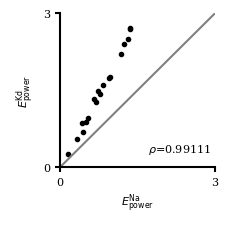

In [38]:
n = n_samp
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    _ = ax.scatter(power_sodium / 10 / 1000, power_kd / 10 / 1000, c="k")
    ax.plot([0, 3], [0, 3], c="gray")
    ax.set_xlim([0, 3])
    ax.set_xticks([0, 3])
    ax.set_ylim([0, 3])
    ax.set_yticks([0, 3])
    ax.text(1.7, 0.3, r"$\rho$"+f"={rho:.5f}")
    ax.set_xlabel(r"$E_{\mathrm{power}}^{\mathrm{Na}}$")
    ax.set_ylabel(r"$E_{\mathrm{power}}^{\mathrm{Kd}}$")
    plt.savefig("../svg/panel_explanation_of_proportionality_f1.svg")

### Show correlation between E_current^{Na,CaT,CaS} and E_power^{Na,CaT,CaS,A,KCa,Kd,H,leak})

In [39]:
reversals = [50, 0, 0, -80, -80, -80, -20, -50]
pump_factors = [3, 4, 4, 2, 2, 2, 2, 2]
all_powers = []
for ci in range(8):
    powers = []
    for index in range(20):
        if ci == 1 or ci == 2:
            _, power, current = viz.energy_of_current(data1, index, ci, data1[index]["reversal_calcium"][neuron][40000:], 40000, 440000, neuron)
        else:
            _, power, current = viz.energy_of_current(data1, index, ci, reversals[ci], 40000, 440000, neuron)
        powers.append(np.sum(power) / 1000 * 0.025)
    all_powers.append(powers)

all_powers = np.asarray(all_powers)
power_all = np.sum(all_powers, axis=0)

In [40]:
reversals = [50, 0, 0, -80, -80, -80, -20, -50]
pump_factors = [3, 4, 4, 2, 2, 2, 2, 2]
all_currents = []
for ci in range(3):
    currents = []
    for index in range(20):
        if ci == 1 or ci == 2:
            _, power, current = viz.energy_of_current(data1, index, ci, data1[index]["reversal_calcium"][neuron][40000:], 40000, 440000, neuron)
        else:
            _, power, current = viz.energy_of_current(data1, index, ci, reversals[ci], 40000, 440000, neuron)
        currents.append(np.sum(current) / 1000 * 0.025 / pump_factors[ci])
    all_currents.append(currents)

all_currents = np.asarray(all_currents)
current_sodium_calcium = np.sum(all_currents, axis=0)

In [41]:
rho = np.corrcoef(power_all, current_sodium_calcium)[0, 1]
print(rho)

0.9999629249221363


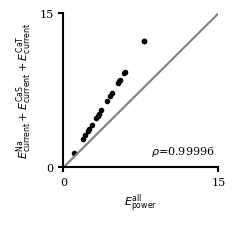

In [42]:
n = n_samp
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    _ = ax.scatter(power_all / 10 / 1000, current_sodium_calcium / 10 / 1.6, c="k")
    ax.plot([0, 15], [0, 15], c="gray")
    ax.set_xlim([0, 15])
    ax.set_xticks([0, 15])
    ax.set_ylim([0, 15])
    ax.set_yticks([0, 15])
    ax.text(8.5, 1.3, r"$\rho$"+f"={rho:.5f}")
    ax.set_xlabel(r"$E_{\mathrm{power}}^{\mathrm{all}}$")
    ax.set_ylabel(r"$E_{\mathrm{current}}^{\mathrm{Na}}+E_{\mathrm{current}}^{\mathrm{CaS}}+E_{\mathrm{current}}^{\mathrm{CaT}}$")
    plt.savefig("../svg/panel_explanation_of_proportionality_f2.svg")

## Assemble figure

In [43]:
import IPython.display as IPd
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [52]:
from svgutils.compose import *
import svgutils.transform as sg

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "4.8cm",

    Panel(
          SVG("../svg/panel_explanation_of_proportionality_d1_large.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("a", 0.0*factor_svg, 0.6*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 2*factor_svg),
           
    Panel(
          SVG("../svg/panel_explanation_of_proportionality_d2.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("b", 0.0*factor_svg, 0.6*factor_svg, **kwargs_text),
    ).move(35*factor_svg, 2*factor_svg),
           
    Panel(
          SVG("../svg/panel_explanation_of_proportionality_d3.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("c", 0.0*factor_svg, 0.6*factor_svg, **kwargs_text),
    ).move(70*factor_svg, 2*factor_svg),
           
    Panel(
          SVG("../svg/panel_explanation_of_proportionality_d4.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("d",0.0*factor_svg, 0.6*factor_svg, **kwargs_text),
    ).move(105*factor_svg, 2*factor_svg),
)

f.save("../fig/fig1_supp_explanation.svg")
svg('../fig/fig1_supp_explanation.svg')

# Sodium

In [47]:
# from svgutils.compose import *
# import svgutils.transform as sg

# # > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# # > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
# svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
# factor_svg=5.5

# # Panel letters in Helvetica Neue, 12pt, Medium
# kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
# kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
# kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
# kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
# kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

# f = Figure("20.3cm", "10.4cm",

#            Panel(
#           SVG("../svg/panel_explanation_of_proportionality_b1.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
#           Text("a", -5.0*factor_svg, 0.6*factor_svg, **kwargs_text),
#     ).move(5*factor_svg, 2*factor_svg),
#     Panel(
#           SVG("../svg/panel_explanation_of_proportionality_a1.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
#           Text("c", 0.0*factor_svg, 0.6*factor_svg, **kwargs_text),
#     ).move(100*factor_svg, 34*factor_svg),
           
#     Panel(
#           SVG("../svg/panel_explanation_of_proportionality_c1.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
#           Text("b", -2.0*factor_svg, 0.6*factor_svg, **kwargs_text),
#     ).move(102*factor_svg, 2*factor_svg),
# )

# f.save("../fig/fig1_supp_explanation.svg")
# svg('../fig/fig1_supp_explanation.svg')

# Investigating energy consumption in detail

In [48]:
from svgutils.compose import *
import svgutils.transform as sg

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "8.7cm",

    Panel(
          SVG("../svg/panel_explanation_of_proportionality_b1.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("a", -3.0*factor_svg, 0.6*factor_svg, **kwargs_text),
    ).move(3*factor_svg, 2*factor_svg),
    Panel(
          SVG("../svg/panel_explanation_of_proportionality_c1.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("b", -0.2*factor_svg, 0.6*factor_svg, **kwargs_text),
    ).move(96.5*factor_svg, 2*factor_svg),
           
    Panel(
          SVG("../svg/panel_explanation_of_proportionality_d1.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("c", -2.0*factor_svg, 0.6*factor_svg, **kwargs_text),
    ).move(98.3*factor_svg, 28*factor_svg),
)

# f.save("../fig/fig1_supp_explanation2.svg")
# svg('../fig/fig1_supp_explanation2.svg')

In [53]:
from svgutils.compose import *
import svgutils.transform as sg

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "5.5cm",

    Panel(
          SVG("../svg/panel_explanation_of_proportionality_e1.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("a", -3.0*factor_svg, 0.6*factor_svg, **kwargs_text),
    ).move(3*factor_svg, 2*factor_svg),
    Panel(
          SVG("../svg/panel_explanation_of_proportionality_e2.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("b", -0.2*factor_svg, 0.6*factor_svg, **kwargs_text),
    ).move(45.5*factor_svg, 2*factor_svg),
    
)

f.save("../fig/fig1_supp_explanation3.svg")
svg('../fig/fig1_supp_explanation3.svg')

In [50]:
from svgutils.compose import *
import svgutils.transform as sg

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("14.3cm", "5.5cm",

    Panel(
          SVG("../svg/panel_explanation_of_proportionality_f1.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("a", -3.0*factor_svg, 0.6*factor_svg, **kwargs_text),
    ).move(3*factor_svg, 2*factor_svg),
    Panel(
          SVG("../svg/panel_explanation_of_proportionality_f2.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("b", -0.2*factor_svg, 0.6*factor_svg, **kwargs_text),
    ).move(45.5*factor_svg, 2*factor_svg),
    
)

f.save("../fig/fig1_supp_explanation4.svg")
svg('../fig/fig1_supp_explanation4.svg')

In [54]:
from svgutils.compose import *
import svgutils.transform as sg

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "5.5cm",

    Panel(
          SVG("../svg/panel_explanation_of_proportionality_e2.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("a", -3.0*factor_svg, 0.6*factor_svg, **kwargs_text),
    ).move(3*factor_svg, 2*factor_svg),
    Panel(
          SVG("../svg/panel_explanation_of_proportionality_f2.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("b", -0.2*factor_svg, 0.6*factor_svg, **kwargs_text),
    ).move(45.5*factor_svg, 2*factor_svg),
    
)

f.save("../fig/fig1_supp_explanation5.svg")
svg('../fig/fig1_supp_explanation5.svg')